# **Goal: Predict how many calories were burned during a workout.**

## **Import Libraries & Data**

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, r2_score

In [2]:
# load data
df = pd.read_csv('/content/train.csv')
tdf = pd.read_csv('/content/test.csv')

## **Exploratory Data Analysis**

In [3]:
# top 5 rows
df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:
# shape
print(f'rows - {df.shape[0]} \ncolumns - {df.shape[1]}')

rows - 750000 
columns - 9


In [5]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [6]:
# check null value
df.isnull().sum()

,0
id,0
Sex,0
Age,0
Height,0
Weight,0
Duration,0
Heart_Rate,0
Body_Temp,0
Calories,0


In [7]:
# check duplicates
df.duplicated().sum()

np.int64(0)

In [8]:
# statistical summary
df.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [9]:
# ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

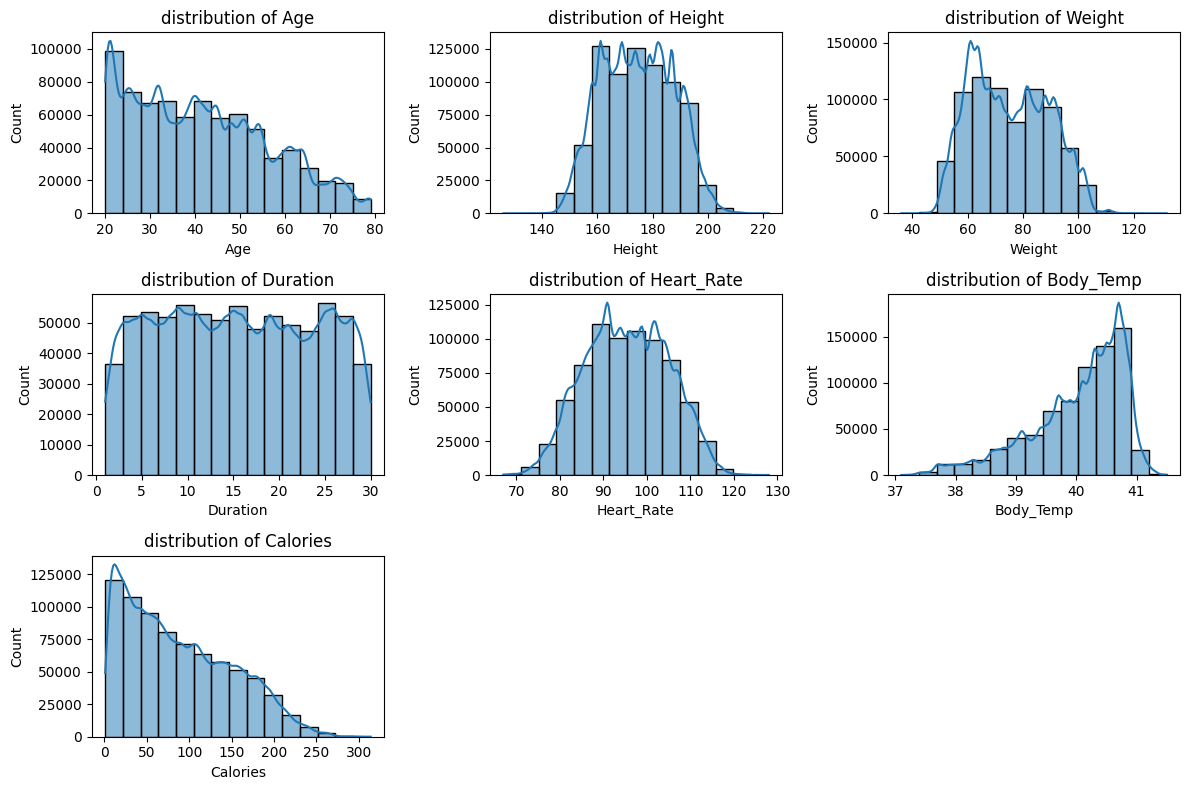

In [10]:
# univariate analysis (frequency of distribution)
features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

plt.figure(figsize=[12, 8])

for i, feature in enumerate(features):
  plt.subplot(3, 3, i+1)
  sns.histplot(data=df, x=feature, bins=15, kde=True)
  plt.title(f'distribution of {feature}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.show()

In [11]:
# checking skewness

skewness = df[features].skew()
print(skewness)

Age           0.436397
Height        0.051777
Weight        0.211194
Duration      0.026259
Heart_Rate   -0.005668
Body_Temp    -1.022361
Calories      0.539196
dtype: float64


- **Calories** moderately positive skewed

- **Body_Temp** highly negative skewed

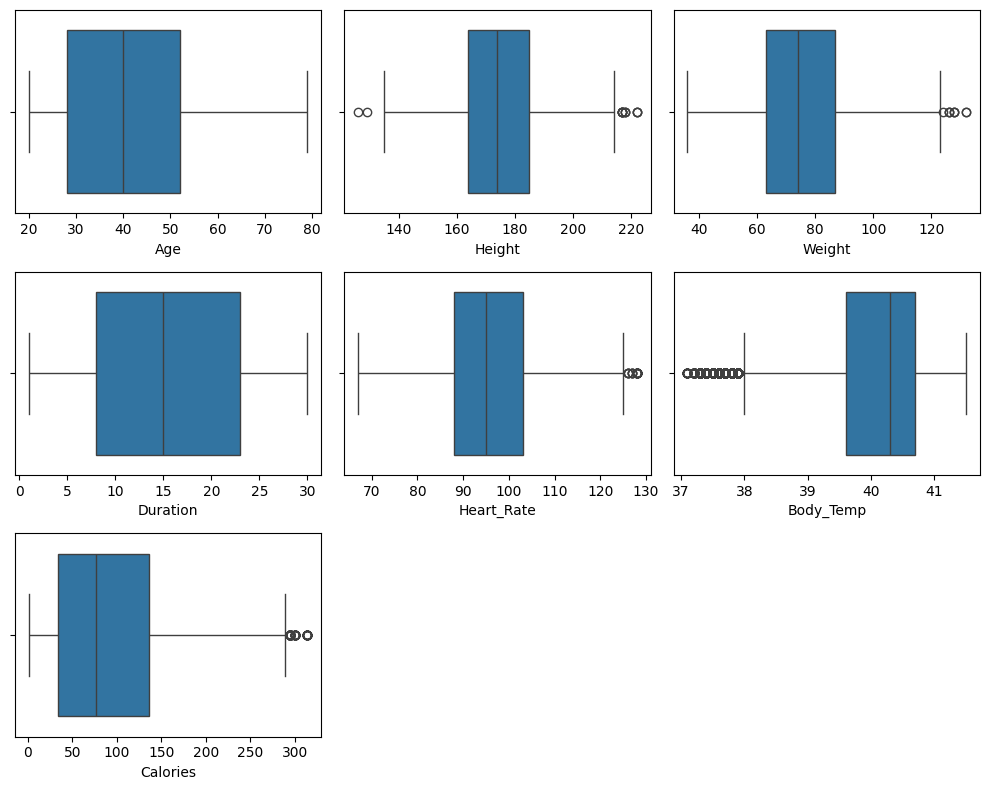

In [12]:
# univariate analysis (outliers)

plt.figure(figsize=(10, 8))

for i, feature in enumerate(features):
  plt.subplot(3, 3, i+1)
  sns.boxplot(data=df, x=feature)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.show()

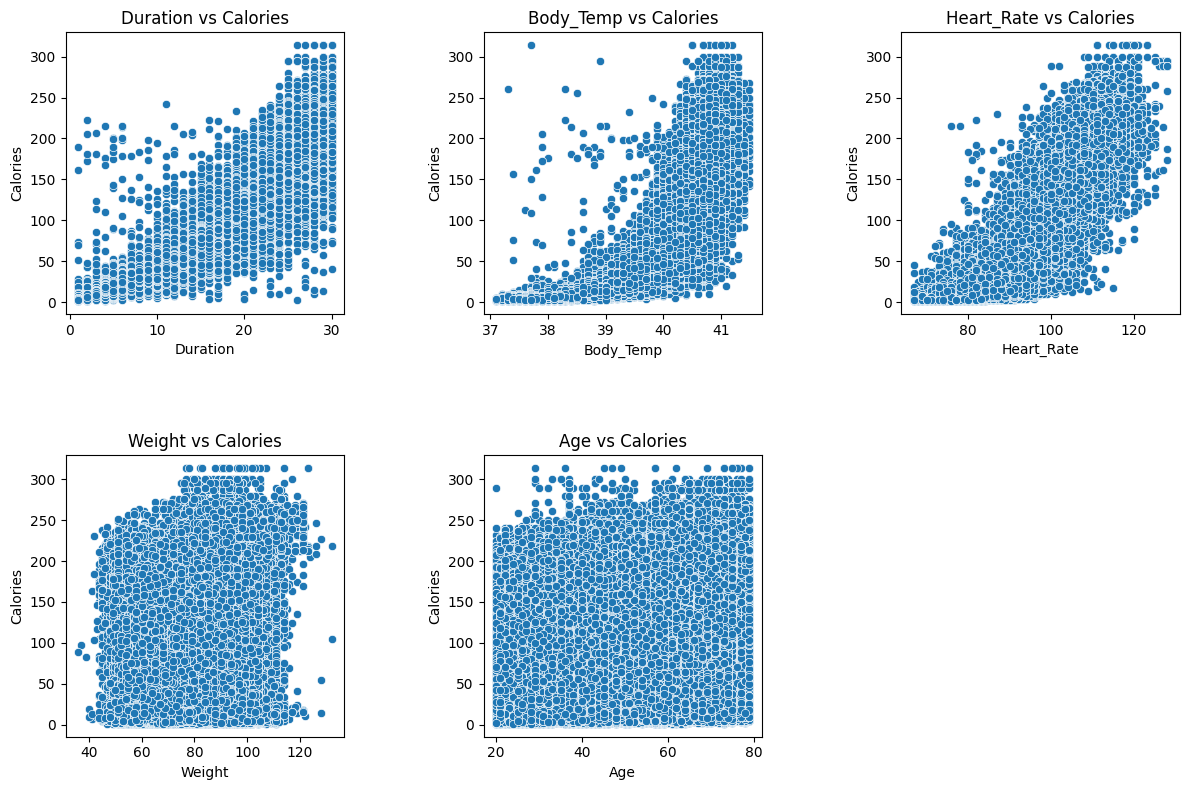

In [13]:
# bivariate analysis (numerical vs numerical)
n_features = ['Duration', 'Body_Temp', 'Heart_Rate', 'Weight', 'Age']

plt.figure(figsize=(12, 8))

for i, feature in enumerate(n_features):
  plt.subplot(2, 3, i+1)
  sns.scatterplot(data=df, x=feature, y='Calories')
  plt.title(f'{feature} vs Calories')

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

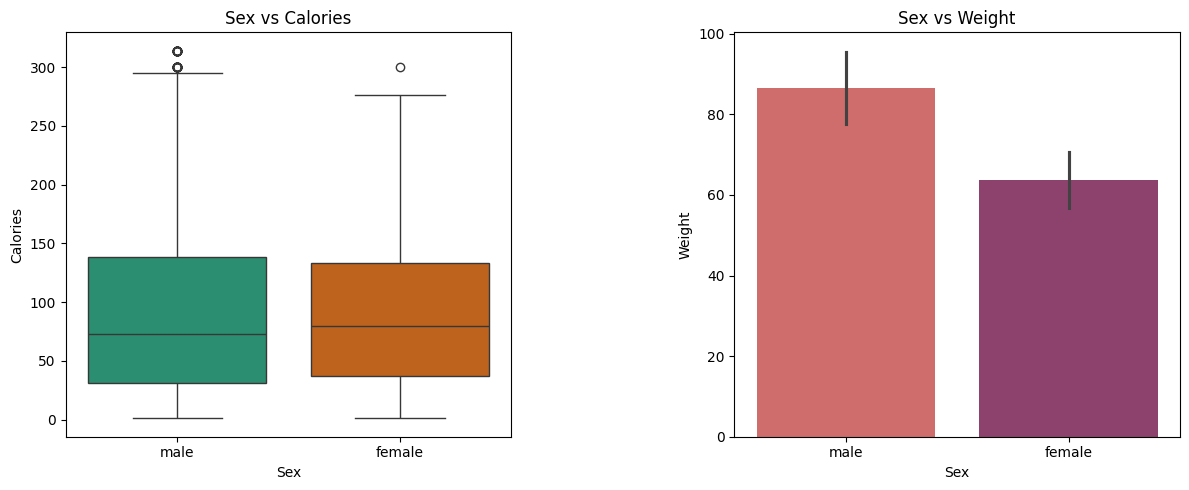

In [14]:
# bivariate analysis (categorical vs numerical)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Sex vs Calories")
plt.xlabel("Sex")
plt.ylabel("Calories")
sns.boxplot(data=df, x='Sex', y='Calories', palette='Dark2')

plt.subplot(1, 2, 2)
plt.title("Sex vs Weight")
plt.xlabel("Sex")
plt.ylabel("Weight")
sns.barplot(data=df, x='Sex', y='Weight', errorbar='sd', palette='flare')

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

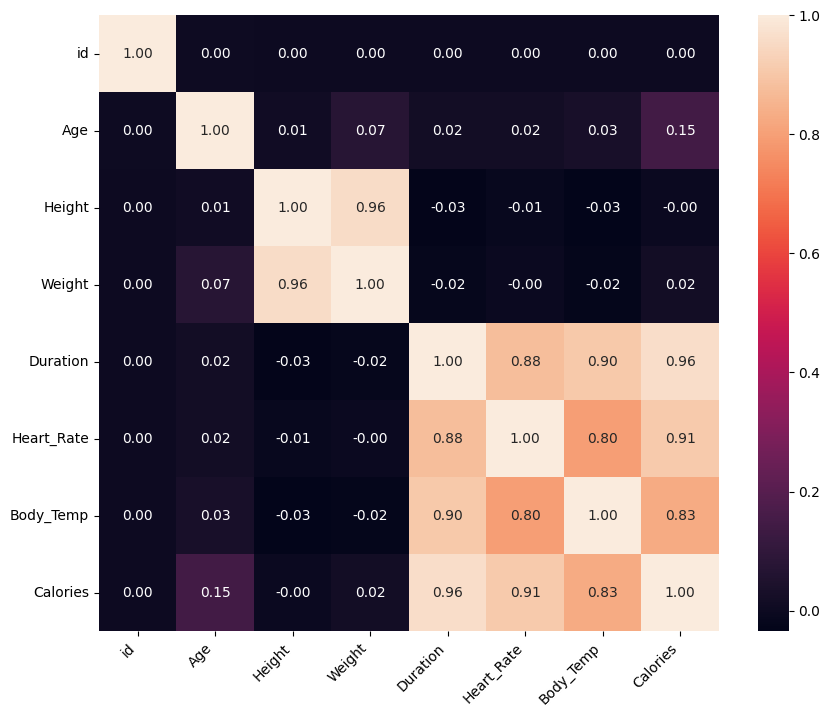

In [15]:
# Correlation

col = df.select_dtypes(include='number')
correlation = col.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt='.2f')
plt.xticks(rotation=45, ha='right')
plt.show()

## **Data Preprocessing**

In [16]:
# converting datatypes
le = LabelEncoder()

# for train data
df['Sex'] = le.fit_transform(df['Sex'])

# for test data
tdf['Sex'] = le.transform(tdf['Sex'])

In [17]:
df.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories'],
      dtype='object')

In [18]:
# outlier using IQR
o_features = ['Duration', 'Body_Temp', 'Heart_Rate', 'Calories']

Q1 = df[o_features].quantile(0.25)
Q3 = df[o_features].quantile(0.75)
IQR = Q3 - Q1

condition = df[(df[o_features] < (Q1 - 1.5*IQR)) | (df[o_features] > (Q3 + 1.5*IQR))]
outliers = df[condition.any(axis=1)]

outliers_sorted = outliers.sort_values(by=['Duration', 'Calories'], ascending=[True, False])
print(outliers_sorted[['Duration', 'Body_Temp', 'Heart_Rate', 'Calories']].head(10))

        Duration  Body_Temp  Heart_Rate  Calories
259984       1.0       37.9       108.0     189.0
475775       1.0       37.8       103.0     161.0
426078       1.0       37.8        86.0      74.0
727021       1.0       37.9       101.0      70.0
47306        1.0       37.4        98.0      52.0
455578       1.0       37.9        94.0      28.0
521482       1.0       37.8        84.0      24.0
264536       1.0       37.9        88.0      21.0
235816       1.0       37.7        85.0      20.0
558872       1.0       37.7        83.0      19.0


In [19]:
# remove outliers
df = df[~condition.any(axis=1)]
df

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,1,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,0,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,0,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,1,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,0,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,1,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,0,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,1,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,1,45,182.0,91.0,17.0,102.0,40.3,109.0


## **ML Pipeline**

In [20]:
# test dataset
tdf.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,1,45,177.0,81.0,7.0,87.0,39.8
1,750001,1,26,200.0,97.0,20.0,101.0,40.5
2,750002,0,29,188.0,85.0,16.0,102.0,40.4
3,750003,0,39,172.0,73.0,20.0,107.0,40.6
4,750004,0,30,173.0,67.0,16.0,94.0,40.5


In [21]:
# train test split

X = df.drop('Calories', axis=1)
y = df['Calories']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# model building & training

model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
# predict on validation set

y_pred = model.predict(X_val)
y_pred

array([  8.829284, 193.51167 ,  22.859837, ..., 134.73065 ,  34.893303,
        62.920975], dtype=float32)

In [24]:
# evaluation

print('Root Mean Squared Logarithmic Error')
rmlse = np.sqrt(mean_squared_log_error(y_val, y_pred))
print(f'RMLSE: {rmlse:.2f}\n')

print('R2 Score')
r2 = r2_score(y_val, y_pred)
print(f'R2 Score: {r2:.2f}')

Root Mean Squared Logarithmic Error
RMLSE: 0.06

R2 Score
R2 Score: 1.00


In [25]:
# final prediction on test data

final_pred = model.predict(tdf)
final_pred

array([ 27.503063, 108.32387 ,  84.265205, ...,  73.157936, 167.74844 ,
        76.68399 ], dtype=float32)

In [26]:
# submission

submission = pd.DataFrame({
    'id': tdf['id'],
    'Calories': final_pred
})

submission

,id,Calories
0,750000,27.503063
1,750001,108.323868
2,750002,84.265205
3,750003,126.456757
4,750004,75.845024
...,...,...
249995,999995,26.151628
249996,999996,9.919112
249997,999997,73.157936
249998,999998,167.748444


In [27]:
# save submission to csv

submission.to_csv('submission.csv', index=False)

## **Thanks for visiting. If you find any useful insights, please consider upvoting!**